In [1]:
import pandas as pd
import os
# import sys to get more detailed Python exception info
import sys
# import the connect library for psycopg2
import psycopg2
# import the error handling libraries for psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import psycopg2.extras as extras
import pandas as pd
from io import StringIO
import numpy as np
from timeit import default_timer as timer
import postgressql
import mlflow
import tempfile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
import helpers as h
import model_evaluation as m_eval
from sklearn.model_selection import RandomizedSearchCV

In [2]:
os.environ['MLFLOW_TRACKING_URI'] = "http://0.0.0.0:8000"
os.environ['MLFLOW_TRACKING_USERNAME'] = "Pablo"

In [3]:
client = mlflow.tracking.MlflowClient()

In [4]:
mlflow.set_experiment("bankchurners_training")

<Experiment: artifact_location='/Users/salv91/Desktop/mlflow_artifactRoot/mlruns/3', experiment_id='3', lifecycle_stage='active', name='bankchurners_training', tags={}>

Accuracy on training set :  0.9998589164785553
Accuracy on test set :  0.9608423823626193
Recall on training set :  0.9991220368744512
Recall on test set :  0.8586065573770492
Precision on training set :  1.0
Precision on test set :  0.8933901918976546
<RunInfo: artifact_uri='/Users/salv91/Desktop/mlflow_artifactRoot/mlruns/3/96ee1f20ad2b4987910724247d207b63/artifacts', end_time=None, experiment_id='3', lifecycle_stage='active', run_id='96ee1f20ad2b4987910724247d207b63', run_uuid='96ee1f20ad2b4987910724247d207b63', start_time=1654025190132, status='RUNNING', user_id='salv91'>


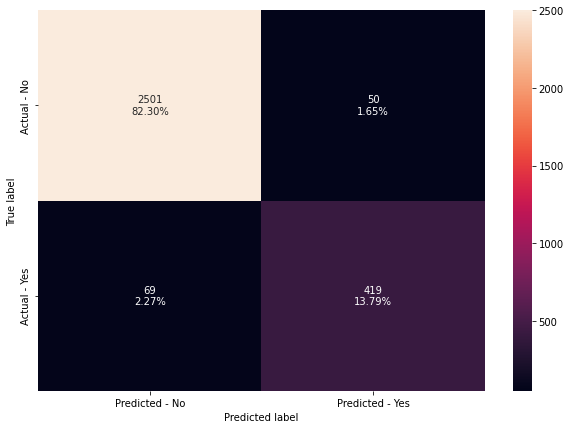

In [5]:
with mlflow.start_run(run_name="Training") as run:
    
    # consume features
    
    df = pd.read_csv("/Users/salv91/Desktop/mlflow_artifactRoot/mlruns/2/f458ae6da86f4003bfdd93625c7d466f/artifacts/Feature_Data/Feature_Data_7k92zmiz.csv",na_values = ["n.a.","?","NA","n/a", "na", "--","nan"],index_col=False)
    
    # Train/test Split
    
    X = df.drop("Attrition_Flag" , axis=1)
    y = df.pop("Attrition_Flag")
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.30, random_state=1, stratify=y)
    
    #register Train/Test
    
    h.register_dataframe(X_train,mlflow_artifact_directory="Training_data",prefix="Training_Data_Features_", suffix=".csv")
    h.register_dataframe(y_train,mlflow_artifact_directory="Training_data",prefix="Training_Data_Target_", suffix=".csv")
    h.register_dataframe(X_test,mlflow_artifact_directory="Training_data",prefix="Test_Data_Features_", suffix=".csv")
    h.register_dataframe(y_test,mlflow_artifact_directory="Training_data",prefix="Test_Data_Target_", suffix=".csv")
        
        
    # Choose the type of classifier. 
    bagging_estimator_tuned = BaggingClassifier(random_state=1,n_jobs=-1)

    # Grid of parameters to choose from
    parameters = {'max_samples': [0.1,0.6,0.9,1], 
                  'max_features': [0.1,0.6,0.8,0.9,1],
                  'n_estimators' : [10,20,40,50,100],
                 }

    # Type of scoring used to compare parameter combinations
    acc_scorer = metrics.make_scorer(metrics.recall_score)
    n_iter_search = 50
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    # Run the grid search
    grid_obj = RandomizedSearchCV(bagging_estimator_tuned, n_iter=n_iter_search, param_distributions=parameters,verbose=0, scoring=acc_scorer,cv=5,n_jobs=4)
    grid_obj = grid_obj.fit(X_train, y_train)

    # Set the clf to the best combination of parameters
    bagging_estimator_tuned = grid_obj.best_estimator_

    # Fit the best algorithm to the data.
    bagging_estimator_tuned.fit(X_train, y_train)
    
    #Logging Model
    mlflow.sklearn.log_model(bagging_estimator_tuned,"model")
    
    ## Evaluation 
    
    test_acc,test_recall,test_precision,bagging_estimator_score=m_eval.get_metrics_score(bagging_estimator_tuned,X_train, X_test, y_train, y_test)
    cm = m_eval.make_confusion_matrix(bagging_estimator_tuned,X_test,y_test)
    
    temp = tempfile.NamedTemporaryFile(prefix="cm", suffix=".jpeg")
    temp_name = temp.name
    
    try:
        cm.figure.savefig(temp_name)
        mlflow.log_artifact(temp_name,"Evaluation")
    finally:
        temp.close() # Delete the temp file 
    
    #Logging Metrics
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_precision", test_precision)
    
    #Logging Parameters 
    params = bagging_estimator_tuned.get_params()
    for i in params: 
        mlflow.log_param(i,params[i])
    
    #print info run
    run_id = run.info.run_id
    mlflow.set_tag("run_id", run_id)
    print(run.info)
    mlflow.end_run()

In [6]:
#mlflow.search_runs(experiment_ids=[""])